<img src="http://www.datacampfire.com/sites/default/files/Data-Campfire-Logo_beta.png">

# Extracting data to visualise from the space 👽 
#### A method for data extraction from satellite to be incorporated as a new data stream in data visualization, using Python and D3

By [Cris Hernández](http://crishernandez.co) for Data Campfire, 2017.

> ## About Data Campfire

> [Data Campfire](http://www.datacampfire.com) is a platform for the data visualisation community, where they collaborate on Data Visualisation Challenges, learn and share.

> We are developing a platform and service that centres around Stories. Stories are showcases or examples of Data Visualisation projects. Stories contain information about the project including what was made, why it was made and how it was made. From this, others on our platform can understand and learn how to use data with context as well as datasets, tools and software that were used. 

> As a core of our business, we host Data Visualisation Events where the data visualisation community work together to solve the problems of organizations. We bring people from different backgrounds; Data Science, Design, Programming, Journalism and many more, so that they produce statistically accurate, and also engaging stories and visuals out of data. 

---

## Libraries

In [27]:
import numpy as np
import rasterio
from rasterio.features import shapes
from rasterio import plot
import geopandas as gpd
import fiona
import matplotlib.pyplot as plt
from matplotlib import pyplot
%matplotlib inline

NOTE: avoiding scroll when rendering images or graphics in general

In [34]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

# A. Preparing our data

## 1. Area of Interest (AOI)
We'll use a Geojson file to find images to process. In this case we are comparing two 'comunas': **Ñuñoa** and **Estación Central**. These comunas are our AOI. We started with two KML files that we found on Internet with these comunas on GeoJson format. We need to transform those KML to GeoJson and then to Shape file.

Vector source: https://www.bcn.cl/siit/mapas_vectoriales/index_html

In [31]:
comunas = gpd.read_file(r'data/division_comunal/division_comunal.shp')
comunas_selected = rm.loc[rm['NOM_COM'].isin(['Estación Central','Ñuñoa'])]
estacion_central = comunas.loc[comunas['NOM_COM'] == 'Estación Central']
nunoa = comunas.loc[comunas['NOM_COM'] == 'Ñuñoa']

In [32]:
estacion_central

,NOM_REG,NOM_PROV,NOM_COM,SHAPE_LENG,DIS_ELEC,CIR_SENA,COD_COMUNA,SHAPE_Le_1,SHAPE_Area,geometry
334,Región Metropolitana de Santiago,Santiago,Estación Central,13054.563524,20,7,1310,19243.649917,1.491563e+07,"POLYGON ((344678.0571999997 6294417.6545, 3446..."


In [33]:
nunoa

,NOM_REG,NOM_PROV,NOM_COM,SHAPE_LENG,DIS_ELEC,CIR_SENA,COD_COMUNA,SHAPE_Le_1,SHAPE_Area,geometry
314,Región Metropolitana de Santiago,Santiago,Ñuñoa,17714.126051,21,8,1312,17848.555565,1.691188e+07,"POLYGON ((353480.1177000003 6295468.6471, 3534..."


In [30]:
our_crs = ("+proj=utm +zone=19 +south +datum=WGS84 +units=m +no_defs")

In [ ]:
estacion_central.crs = our_crs
estacion_central.to_file(driver = 'ESRI Shapefile', filename= "data/estacion_central.shp")

In [ ]:
nunoa.crs = our_crs
nunoa.to_file(driver = 'ESRI Shapefile', filename= "data/nunoa.shp")

Finally we want to transform our Shapefile to GeoJSON. For this process we will use GDAL command line tool, running the following command:

> ogr2ogr -f GeoJSON -t_srs crs:84 [name].geojson [name].shp

(*) Replace 'name' with your SHP file.

We are ready to go and download our sattelite images!!!

## 2. Getting Sattelite Images

Now we need to search and download our sattelite images. We are using [Earth Observing System](https://eos.com/) service for that. EOS is a company aimed to collect imaginery from all over the world. Particularly we'll use the [Land Viewer](https://eos.com/landviewer) tool, which allow us to find images from [Landsat8](https://landsat.usgs.gov/landsat-8) and [Sentinel](http://www.esa.int/Our_Activities/Observing_the_Earth/Copernicus/Overview4) sattelites. 

![](img/landviewer.png)

In order to get sattelite images from our AOIs we just upload our GeoJson files. In this way we are narrowing our search to just our AOI (ñuñoa and estacion central).

![](img/upload.png)

### A. Calculate NDVI 

> "NDVI values range from +1.0 to -1.0. Areas of barren rock, sand, or snow usually show very low NDVI values (for example, 0.1 or less). Sparse vegetation such as shrubs and grasslands or senescing crops may result in moderate NDVI values (approximately 0.2 to 0.5). High NDVI values (approximately 0.6 to 0.9) correspond to dense vegetation such as that found in temperate and tropical forests or crops at their peak growth stage." [Source](https://phenology.cr.usgs.gov)

In order to calculate NDVI we need two images: Red and NIR:

![](img/getTiff.png)

In [35]:
! cd data/imagenes && ls

NIR.tif         NIR.tif.aux.xml RED.tif         RED.tif.aux.xml


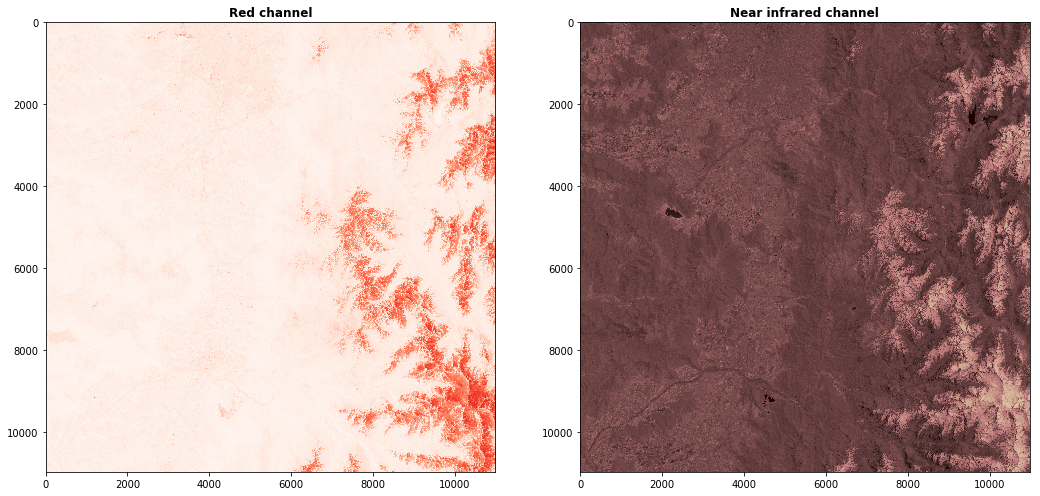

In [37]:
red = r"data/imagenes/RED.tif"
nir = r"data/imagenes/NIR.tif"

red_band = rasterio.open(red)
nir_band = rasterio.open(nir)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,7))
plot.show(red_band, ax=ax1, cmap='Reds', title='Red channel')
plot.show(nir_band, ax=ax2, cmap='pink', title='Near infrared channel')
fig.tight_layout()

In [36]:
# Function to calculate NDVI
def getNDVI(red,nir):
    path = r'data/ndvi.tif'
    
    with rasterio.open(red) as src:
        b3 = src.read(1)
    
    with rasterio.open(nir) as src:    
        b4 = src.read(1)
    
    np.seterr(divide='ignore', invalid='ignore') # Allow division by zero
    ndvi = (b4.astype(float) - b3.astype(float)) / (b4 + b3) # Calculate NDVI
    
    # Set spatial characteristics of the output object to mirror the input
    kwargs = src.meta
    kwargs.update(dtype=rasterio.float32,count = 1)

    with rasterio.open(path, 'w', **kwargs) as dst:
        dst.write_band(1, ndvi.astype(rasterio.float32))    

In [65]:
getNDVI(red,nir)

/usr/local/lib/python3.6/site-packages/rasterio/__init__.py:160: FutureWarning: GDAL-style transforms are deprecated and will not be supported in Rasterio 1.0.
  transform = guard_transform(transform)


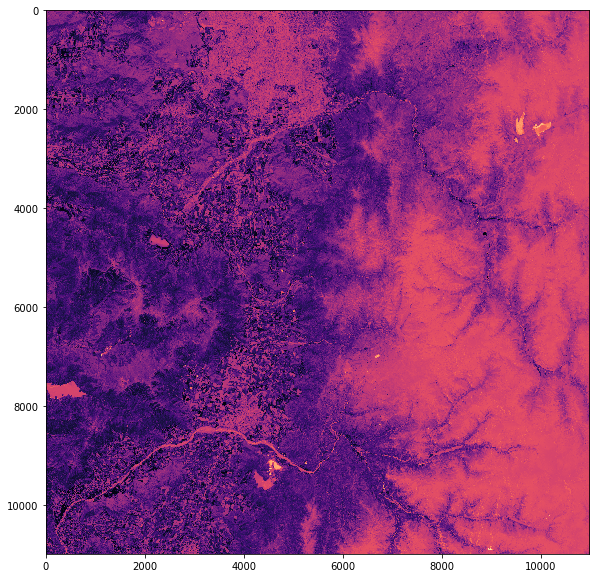

In [5]:
ndvi = rasterio.open(r"data/ndvi.tif")
plt.figure(figsize=(10,10))
plot.show(ndvi, cmap='magma_r')

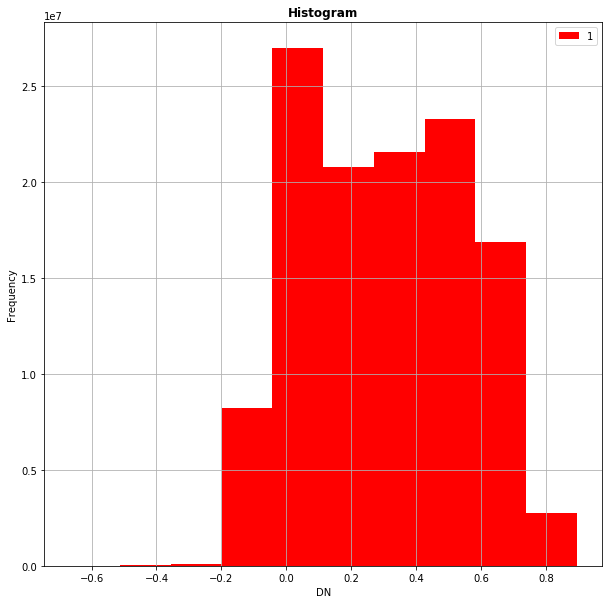

In [7]:
plt.figure(figsize=(10,10))
plot.show_hist(ndvi)

### B. Clip Raster file using a SHP (Clip NDVI / Comunas SHP)
Frome here: https://github.com/dwtkns/gdal-cheat-sheet

- gdalwarp -dstnodata -9999 -cutline nunoa.shp ndvi.tif nunoa.tif 
- gdalwarp -dstnodata -9999 -cutline estacion_central.shp ndvi.tif estacion_central.tif

This is our result:

![](img/result_clipped.png)

### C. Getting "Healthy Vegetation"

In general NDVI healthy vegetation are all the values above 0.3.

In [57]:
# Reading back our sattelite images
with rasterio.drivers():
    with rasterio.open(r"data/nunoa.tif") as src:
        image = src.read(1)
        results = (
            {'properties': {'raster_val': v}, 'geometry': s}
            for i, (s, v) in enumerate(shapes(image, mask=None, transform=src.affine)))

        nunoa_geoms = list(results)

nunoa_geoms[0]

{'geometry': {'coordinates': [[(352910.0, 6299500.0),
    (352910.0, 6299490.0),
    (352920.0, 6299490.0),
    (352920.0, 6299500.0),
    (352910.0, 6299500.0)]],
  'type': 'Polygon'},
 'properties': {'raster_val': 0.16472114622592926}}

In [58]:
nunoa_h = gpd.GeoDataFrame.from_features(nunoa_geoms)
nunoa_h.head()

,geometry,raster_val
0,"POLYGON ((352910 6299500, 352910 6299490, 3529...",0.164721
1,"POLYGON ((352920 6299500, 352920 6299490, 3529...",0.328302
2,"POLYGON ((352900 6299490, 352900 6299480, 3529...",0.068397
3,"POLYGON ((352910 6299490, 352910 6299480, 3529...",0.126254
4,"POLYGON ((352920 6299490, 352920 6299480, 3529...",0.200702


#### Function to calculate our Helthy Vegetation

In [93]:
def healthyVeg(imagenPath,comuna):

    with rasterio.drivers():
        with rasterio.open(imagenPath) as src:
            image = src.read(1)
            results = (
            {'properties': {'raster_val': v}, 'geometry': s}
            for i, (s, v) in enumerate(shapes(image, mask=None, transform=src.affine)))

    geoms = list(results)
    
    df = gpd.GeoDataFrame.from_features(geoms)
#     veg = df.loc[df['raster_val'] >= 0.3]
    veg = df[(df['raster_val'] >= 0.3) & (df['raster_val'] <= 0.5)]
    
    return veg

In [94]:
nunoa_polygons = healthyVeg(r"data/nunoa.tif",nunoa)
estacion_central_polygons = healthyVeg(r"data/estacion_central.tif",estacion_central)

In [98]:
nunoa_polygons.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 44677 entries, 1 to 169103
Data columns (total 2 columns):
geometry      44677 non-null object
raster_val    44677 non-null float64
dtypes: float64(1), object(1)
memory usage: 1.0+ MB


In [96]:
estacion_central_polygons.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 15573 entries, 14 to 149115
Data columns (total 2 columns):
geometry      15573 non-null object
raster_val    15573 non-null float64
dtypes: float64(1), object(1)
memory usage: 365.0+ KB


In [103]:
nunoa_polygons.crs = our_crs
nunoa_polygons.to_file(driver = 'ESRI Shapefile', filename= 'data/nunoa_green.shp')

In [104]:
estacion_central_polygons.crs = our_crs
estacion_central_polygons.to_file(driver = 'ESRI Shapefile', filename= 'data/estacion_central_green.shp')

### Our result

![](img/green.png)

### Thinks to do:
- D3 viz: https://d3plus.org/examples/d3plus-geomap/custom-color/ or http://d3plus.org/examples/d3plus-geomap/getting-started/

Rasterio documentation: https://mapbox.github.io/rasterio/topics/plotting.html